# Algorithm: SVM
Acknowledgement: Most of the code was referenced from Prof. Mafas Raheem's AML lab-8.
## Model Validation Strategy
Three models evaluated with two different datasets as described below (altogether 6 models).
### Standard dataset (without class balancing)
- Base
- Grid-Search-CV
- Random-Search-CV
### Oversampled dataset (with class balancing)
- Base
- Grid-Search-CV
- Random-Search-CV
### Conclusion (for all evaluations)
- accuracy chart

In [20]:
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

import custom_libs.evaluation_helper as ev
import models.uci_heart_disease_dataset as uci

# Warning was disabled to capture errors and warning. Can be enabled when needed.
warnings.filterwarnings("ignore")

In [21]:
# Load the preprocessed dataset (299 records; with 14 features)
data = pd.read_csv(uci.UCIHeartDiseaseDataFile.cleveland_preprocessed, names = uci.get_standard_features())
print(f'Data shape: {data.shape}.')
data.head(3)

Data shape: (299, 14).


,Age,Gender,Chest Pain,BP Systolic,Cholesterol,Blood Sugar,Rest ECG,Exe. Max Heartrate,Exe. Induced Angina,Exe. ST Depression,Exe. ST Segment Slope,Major Vessels,Thalassemia,Target
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286.0,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229.0,0,2,129,1,2.6,2,2,7,1


# Set Models' Hyperparameters and Cross-Validation Strategy

In [22]:
# Verbose variable for log inspection.
verbose = False

# Dictionary to hold hyperparameters for grid and random search.
parameters = dict()
parameters['kernel'] = ['rbf', 'poly', 'linear', 'sigmoid']
parameters['C'] = arange(1, 10, 1) ## Tried with 30, only 1 was chosen.
parameters['gamma'] = ['scale', 'auto']
parameters['class_weight'] = ['dict', 'balanced']

# A stratified K fold for cross-validation strategy - values are assigned from the evaluation helper module.
# When random state is enabled, shuffle has to be enabled to. Shuffle is done before the deterministic split (sklearn doc).
skfolds = StratifiedKFold(n_splits = ev.kfold_n_split,
                          shuffle = ev.kfold_shuffle,
                          random_state = ev.random_state)

# Dict for storing accuracies and drawing chart in the conclusion section.
ev.accuracies = {}

# Base Model (Function)

In [23]:
# A function to build base model.
def build_and_validate_base_model(x_train, x_test, y_train, y_test, test_name):
    print(f'\nEvaluation name: {test_name}.')

    # Train the model with training set.
    svc= SVC(verbose=verbose, random_state=ev.random_state)
    svc.fit(x_train, y_train)

    # Display the hyperparameters used.
    print(f'Params         :{ svc.get_params()}.')

    # Do prediction with the train model.
    y_pred = svc.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve and return accuracy.
    return ev.display_validation_report(y_test, y_pred, x_test, svc)

# Grid Search CV (Function)

In [24]:
# A function discover the model's best hyperparameters and perform cross-validation using GridSearchCV.
def build_and_validate_with_grid_search_cv(x_train, x_test, y_train, y_test, test_name):
    print(f'\nEvaluation name: {test_name}.')

    svc= SVC(verbose=verbose, random_state=ev.random_state)

    # Build Grid-search with parameters and stratified k fold strategy for cross-validation.
    grid_scv = GridSearchCV(svc, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's best hyperparameters for optimal performance.
    grid_scv.fit(x_train,y_train)

    # Display the best hyperparameters and score. The best score is mean of CV scores for train-set.
    print(f'Best params         :{grid_scv.best_params_}.')
    print(f'Best score (*mean)  :{grid_scv.best_score_}.')

    # Predict using the trained model on the test-set.
    y_pred = grid_scv.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve and return accuracy.
    return ev.display_validation_report(y_test, y_pred, x_test, grid_scv)

# Random Search CV (Function)

In [25]:
# A function discover the model's best hyperparameters and perform cross-validation using RandomSearchCV.
def build_and_validate_with_random_search_cv(x_train, x_test, y_train, y_test, test_name):
    print(f'\nEvaluation name: {test_name}.')

    svc= SVC(verbose=verbose, random_state=ev.random_state)

    # Build Random-search with parameters and stratified k fold strategy for cross-validation.
    rand_scv = RandomizedSearchCV(svc, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's best hyperparameters for optimal performance.
    rand_scv.fit(x_train,y_train)

    # Display the best hyperparameters and score. The best score is mean of CV scores for train-set.
    print(f'Best params         :{rand_scv.best_params_}.')
    print(f'Best score (*mean)  :{rand_scv.best_score_}.')

    # Predict using the trained model on the test-set.
    y_pred = rand_scv.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curv and return accuracy.
    return ev.display_validation_report(y_test, y_pred, x_test, rand_scv)

# Evaluation with Standard Dataset (without class balancing)

### Data Preparation

Class counter (stratified):
Entire-set  : Counter({0: 160, 1: 139}).
Train-set   : Counter({0: 128, 1: 111}).
Test-set    : Counter({0: 32, 1: 28}).


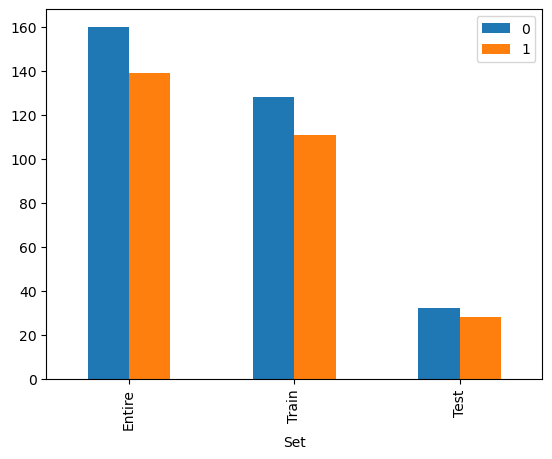

In [26]:
# Prepare features and target variables.
X = data.drop(uci.UCIHeartDiseaseData.target, axis = 1)
y = data[uci.UCIHeartDiseaseData.target]

# Calls the evaluation helper module to scale features and do split (classes are balanced using stratify split).
X_train, X_test, Y_train, Y_test = ev.scale_and_split(X, y)

# Display the counter for '1' and '0' in y set before splitting.
print('Class counter (stratified):')
print(f'Entire-set  : {Counter(y)}.')
print(f'Train-set   : {Counter(Y_train)}.')
print(f'Test-set    : {Counter(Y_test)}.')

std_y_data = [['Entire', Counter(y).get(0), Counter(y).get(1)],
              ['Train', Counter(Y_train).get(0), Counter(Y_train).get(1)],
              ['Test', Counter(Y_test).get(0), Counter(Y_test).get(1)]]

pd.DataFrame(std_y_data, columns=['Set', '0', '1']).set_index('Set').plot.bar();


Evaluation name: std-base.
Params         :{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}.

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        32
           1       0.84      0.75      0.79        28

    accuracy                           0.82        60
   macro avg       0.82      0.81      0.81        60
weighted avg       0.82      0.82      0.82        60

Actual accuracy result: 81.66666666666667.
Parsed accuracy result: 82.0.

Confusion Matrix


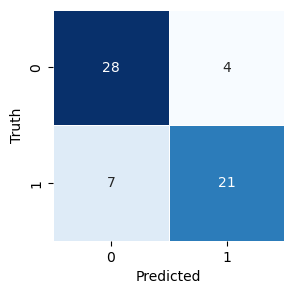

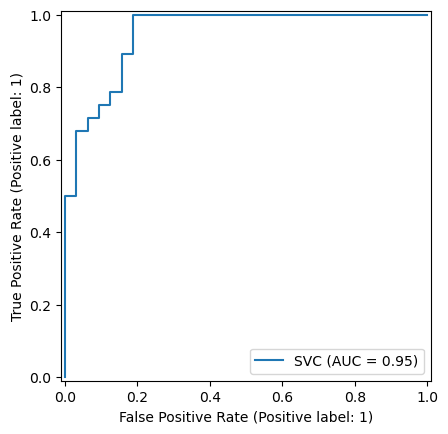

In [27]:
# Evaluation: Standard Base
acc = build_and_validate_base_model(X_train, X_test, Y_train, Y_test, ev.EvaluationType.std_base)
ev.accuracies[ev.EvaluationType.std_base] = acc


Evaluation name: std-grid-scv.
Best params         :{'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}.
Best score (*mean)  :0.8326241134751772.

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.85      0.79      0.81        28

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60

Actual accuracy result: 83.33333333333334.
Parsed accuracy result: 83.0.

Confusion Matrix


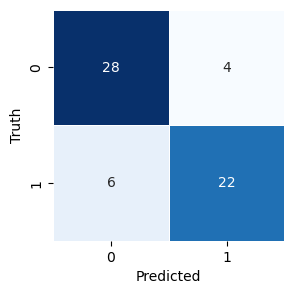

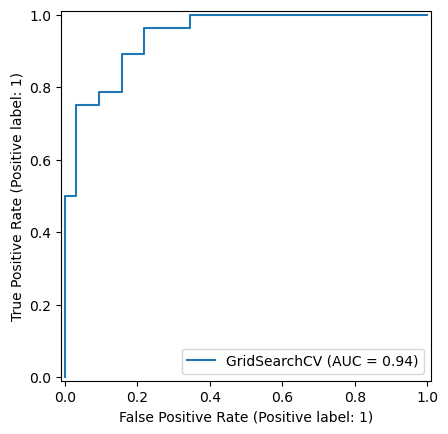

In [28]:
# Evaluation: Standard Grid Search CV
acc = build_and_validate_with_grid_search_cv(X_train, X_test, Y_train, Y_test, ev.EvaluationType.std_grid_search_cv)
ev.accuracies[ev.EvaluationType.std_grid_search_cv] = acc


Evaluation name: std-rand-scv.
Best params         :{'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced', 'C': 5}.
Best score (*mean)  :0.8326241134751772.

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.85      0.79      0.81        28

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60

Actual accuracy result: 83.33333333333334.
Parsed accuracy result: 83.0.

Confusion Matrix


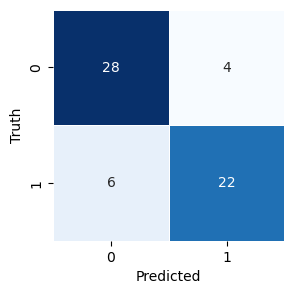

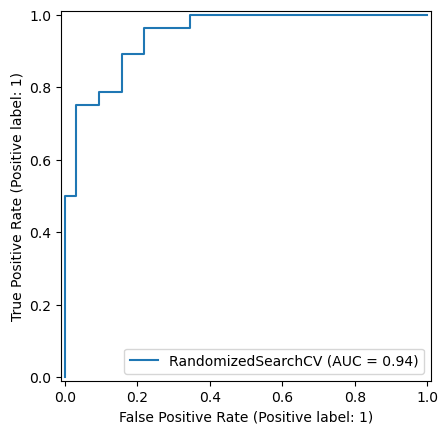

In [29]:
# Evaluation: Standard Random Search CV
acc = build_and_validate_with_random_search_cv(X_train, X_test, Y_train, Y_test, ev.EvaluationType.std_random_search_cv)
ev.accuracies[ev.EvaluationType.std_random_search_cv] = acc

In [30]:
print(f'Accuracies : {ev.accuracies}.')

Accuracies : {'std-base': 82.0, 'std-grid-scv': 83.0, 'std-rand-scv': 83.0}.


# Evaluation with Oversampled Dataset (with class balancing)

### Data Preparation and Oversampling

Class counter (stratified):
Entire-set  : Counter({0: 160, 1: 160}).
Train-set   : Counter({1: 128, 0: 128}).
Test-set    : Counter({1: 32, 0: 32}).


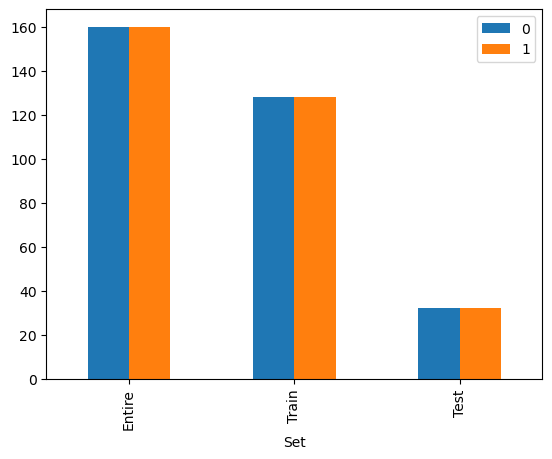

In [31]:
# Prepare features and target variables from original data frame.
X = data.drop(uci.UCIHeartDiseaseData.target, axis=1)
y = data[uci.UCIHeartDiseaseData.target]

# Perform over-sampling with SMOTE
X_b, y_b = SMOTE(random_state=ev.random_state).fit_resample(X, y)

# Scale and spit the oversampled data.
Xb_train, Xb_test, Yb_train, Yb_test = ev.scale_and_split(X_b, y_b)

# Display the counter for '1' and '0' in y set before splitting.
print('Class counter (stratified):')
print(f'Entire-set  : {Counter(y_b)}.')
print(f'Train-set   : {Counter(Yb_train)}.')
print(f'Test-set    : {Counter(Yb_test)}.')

os_y_data = [['Entire', Counter(y_b).get(0), Counter(y_b).get(1)],
              ['Train', Counter(Yb_train).get(0), Counter(Yb_train).get(1)],
              ['Test', Counter(Yb_test).get(0), Counter(Yb_test).get(1)]]

pd.DataFrame(os_y_data, columns=['Set', '0', '1']).set_index('Set').plot.bar();

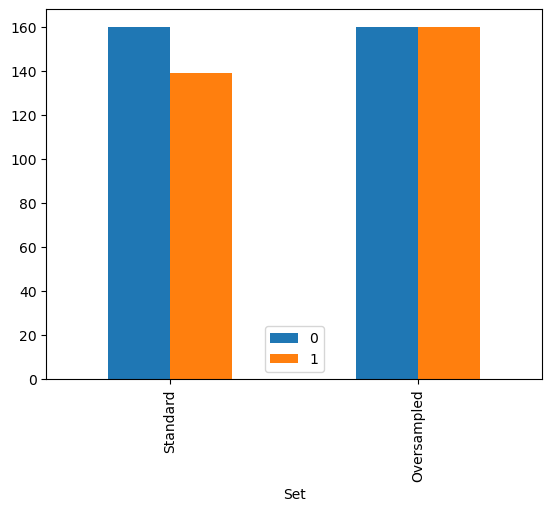

In [32]:
# Before and after oversampling
target_set_data = [['Standard', Counter(y).get(0), Counter(y).get(1)],
                   ['Oversampled', Counter(y_b).get(0), Counter(y_b).get(1)]]

pd.DataFrame(target_set_data, columns=['Set','0','1']).set_index('Set').plot.bar();


Evaluation name: os-base.
Params         :{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}.

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.88      0.81        32
           1       0.85      0.72      0.78        32

    accuracy                           0.80        64
   macro avg       0.80      0.80      0.80        64
weighted avg       0.80      0.80      0.80        64

Actual accuracy result: 79.6875.
Parsed accuracy result: 80.0.

Confusion Matrix


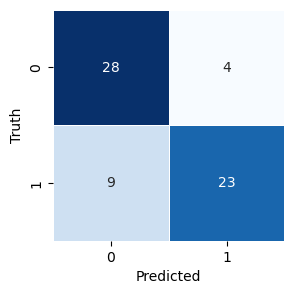

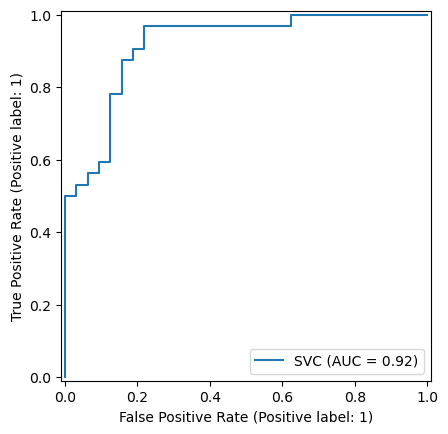

In [33]:
# Evaluation: Over-sampled Base
acc = build_and_validate_base_model(Xb_train, Xb_test, Yb_train, Yb_test, ev.EvaluationType.os_base)
ev.accuracies[ev.EvaluationType.os_base] = acc


Evaluation name: os-grid-scv.
Best params         :{'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}.
Best score (*mean)  :0.8244343891402716.

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.88      0.81        32
           1       0.85      0.72      0.78        32

    accuracy                           0.80        64
   macro avg       0.80      0.80      0.80        64
weighted avg       0.80      0.80      0.80        64

Actual accuracy result: 79.6875.
Parsed accuracy result: 80.0.

Confusion Matrix


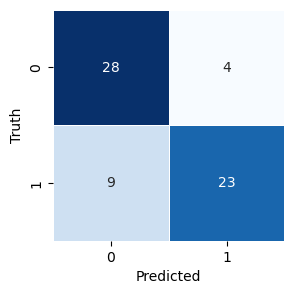

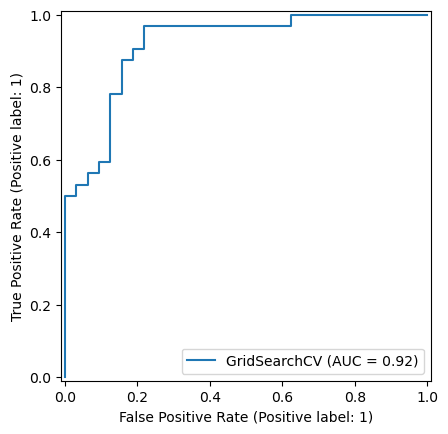

In [34]:
# Evaluation: Over-sampled Grid Search CV
acc = build_and_validate_with_grid_search_cv(Xb_train, Xb_test, Yb_train, Yb_test, ev.EvaluationType.os_grid_search_cv)
ev.accuracies[ev.EvaluationType.os_grid_search_cv] = acc


Evaluation name: os-rand-scv.
Best params         :{'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 5}.
Best score (*mean)  :0.8086726998491705.

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.81      0.76        32
           1       0.79      0.69      0.73        32

    accuracy                           0.75        64
   macro avg       0.75      0.75      0.75        64
weighted avg       0.75      0.75      0.75        64

Actual accuracy result: 75.0.
Parsed accuracy result: 75.0.

Confusion Matrix


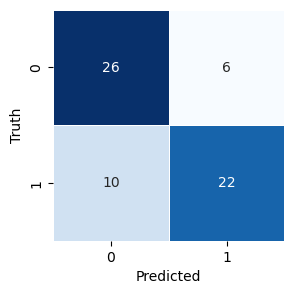

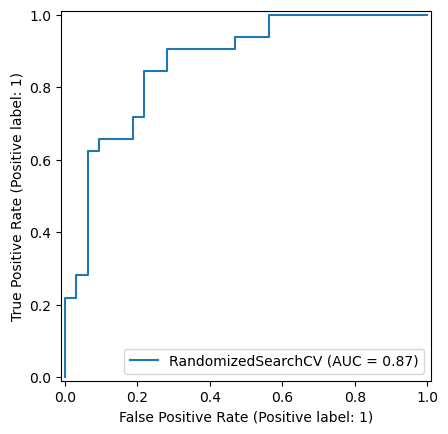

In [35]:
# Evaluation: Over-sampled Random Search CV
acc = build_and_validate_with_random_search_cv(Xb_train, Xb_test, Yb_train, Yb_test, ev.EvaluationType.os_random_search_cv)
ev.accuracies[ev.EvaluationType.os_random_search_cv] = acc

In [36]:
print(f'Accuracies : {ev.accuracies}.')

Accuracies : {'std-base': 82.0, 'std-grid-scv': 83.0, 'std-rand-scv': 83.0, 'os-base': 80.0, 'os-grid-scv': 80.0, 'os-rand-scv': 75.0}.


# Conclusion

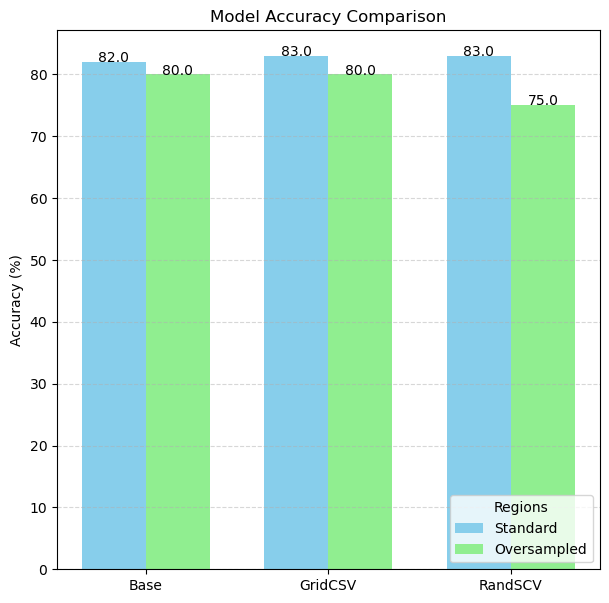

Model types             : ['Base', 'GridCSV', 'RandSCV'].
Standard accuracies     : [82.0, 83.0, 83.0].
Oversampled accuracies  : [80.0, 80.0, 75.0].
Accuracies (dict)       : {'std-base': 82.0, 'std-grid-scv': 83.0, 'std-rand-scv': 83.0, 'os-base': 80.0, 'os-grid-scv': 80.0, 'os-rand-scv': 75.0}.


In [37]:
# Function to display value on the bar chart.
def add_labels(x_pos, y_pos, delta):
    for i in range(len(x_pos)):
        dist = i + delta
        plt.text(dist, y_pos[i], y_pos[i], ha = 'center')

acc_model_type = ['Base', 'GridCSV', 'RandSCV']
bar_width = 0.35
x = np.arange(len(acc_model_type))

# Bar Plot size
plt.figure(figsize = (7,7))

# Set standard bar type and values.
acc_standard_data = [
    ev.accuracies[ev.EvaluationType.std_base],
    ev.accuracies[ev.EvaluationType.std_grid_search_cv],
    ev.accuracies[ev.EvaluationType.std_random_search_cv]
]
# Set oversampled bar type and values.
acc_oversampled_data = [
    ev.accuracies[ev.EvaluationType.os_base],
    ev.accuracies[ev.EvaluationType.os_grid_search_cv],
    ev.accuracies[ev.EvaluationType.os_random_search_cv]
]
plt.bar(x - bar_width / 2, acc_standard_data, bar_width, label='Standard', color='skyblue')
plt.bar(x + bar_width / 2, acc_oversampled_data, bar_width, label='Oversampled', color='lightgreen')

# Display value on the bar chart.
add_labels(acc_model_type,acc_standard_data,-(bar_width/2))
add_labels(acc_model_type,acc_oversampled_data, bar_width/2)

# Adding labels and title
plt.title('Model Accuracy Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylabel('Accuracy (%)')
plt.xticks(x, acc_model_type)
plt.legend(title='Regions', loc='lower right')
plt.show();

# For debugging values.
print(f'Model types             : {acc_model_type}.')
print(f'Standard accuracies     : {acc_standard_data}.')
print(f'Oversampled accuracies  : {acc_oversampled_data}.')
print(f'Accuracies (dict)       : {ev.accuracies}.')

In [38]:
# Since, GridSCV perform more extensive cross-validation compared to RandSCV to ensure model's stability, the highest score between
# standard data and oversampled data for GridSCV is selected.
grid_accuracies = [ev.accuracies[ev.EvaluationType.std_grid_search_cv], ev.accuracies[ev.EvaluationType.os_grid_search_cv]]

print(f'Grid accuracies     : {grid_accuracies}.')

# Set the global score for comparisons.
ev.set_accuracy('SVM', int(max(grid_accuracies)))
global_accuracies  = ev.get_accuracies()
print(f'Highest accuracy    : {global_accuracies['SVM']}')
print(f'Global-result       : {global_accuracies}')

Grid accuracies     : [83.0, 80.0].
Highest accuracy    : 83
Global-result       : {'NB': 87, 'DT': 82, 'LR': 88, 'SVM': 83, 'RF': 83, 'KNN': 85, 'Latest': '2024-12-30 23:21:30'}
